In [1]:
# In this repository, we're gonna apply the Kalman filter to AR(2) process in order to obtain the better forecast
# This process consists of 2 separate process, (i) estimation, and (2) forecasting
# This section focuses more on prediction and the application of Kalman filter rather than estimation.

# Import the important packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
# The AR(2) process is represented by the following equation:
# y(t) = a + b.y(t-1) + c.y(t-2) + e(t), in which e(t) is normally distribution with mean 0 and standard deviation sig(t)

# To estimate, we can use many choices, but in this case, we will use the OLS estimator for the ease of application. Further
# extension is considered later using more advanced techniques, such as likelihood or Bayesian approach, or taking the stochastic
# volatility into account.

def OLS_estimation(data):
    # Firstly, process the data
    # Flip the data
    n = len(data)
    y = data[::-1]
    p = 2
    if y.shape[0] > 1:
        Y_bold = y[:len(y)-p]
        y1 = y[1:len(y)-p+1]
        y2 = y[2:]
    else:
        Y_bold = np.transpose(y[:len(y)-p])
        y1 = np.transpose(y[1:len(y)-p+1])
        y2 = np.transpose(y[2:])
    X = np.column_stack((np.ones((len(Y_bold),1),dtype = int),y1,y2))
    # Now, we have Y is the left-hand-side variable and X is the set of right-hand-side variables
    # The OLS estimator:
    beta = np.matmul(inv(np.matmul(np.transpose(X),X)),(np.matmul(np.transpose(X),Y_bold)))
    # Now, we estimate the variance-covariance matrix of the error terms
    res = Y_bold - X.dot(beta)
    sig_hat = 1/(n-p+1)*np.matmul(np.transpose(res),res)
    return (beta, sig_hat)

<function matplotlib.pyplot.show(*args, **kw)>

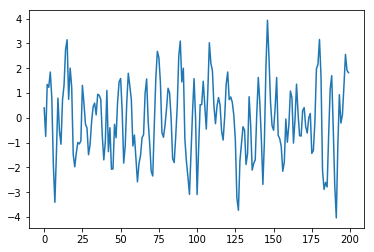

In [3]:
# Simulation
p = 2
a = 0
b = 1
c = -1/2
sig = 1

data = np.zeros((200,1),dtype = float)
data[0] = np.random.normal(0,1)
data[1] = np.random.normal(0,1)

# Data generating process
for i in range(200)[2:]:
    data[i] = a + b*data[i-1] + c*data[i-2] + np.random.normal(0,sig)
    
# Visualize the data
_ = plt.figure
_ = plt.plot(range(0,200),data)
plt.show

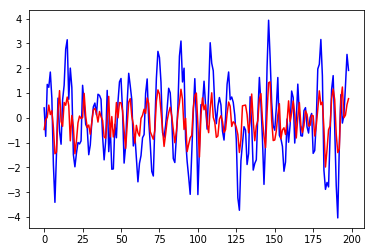

In [4]:
# Now, move on to the Kalman filter application. First of all, construct the neccessary matrices
alpha = float(OLS_estimation(data)[0][0])
phi1 = float(OLS_estimation(data)[0][1])
phi2 = float(OLS_estimation(data)[0][2])

T = np.array([[phi1, phi2],[1, 0]])
R = np.array([[1],[0]])
c = np.array([[alpha],[0]])
Q = OLS_estimation(data)[1]
Z = np.array([1,0])
dt = 0
H = 0

# Compute parameters of the initial state
a0 = inv(np.identity(p, dtype = float)-T).dot(c)
P0 = np.reshape(inv(np.identity(p**2, dtype = float)-np.kron(T,T)).dot(np.reshape(R.dot(Q).dot(np.transpose(R)),(p**2,1))),(p,p))

# Draw the initial state
alpha0 = np.transpose(np.random.multivariate_normal(np.array(a0).flatten(),P0,1).flatten())

# Create an empty matrix to store the result
result = np.zeros((2,len(data)-1), dtype = float)
result[:,0] = alpha0
P_old = P0

# Reshape the data
row1 = data[:len(data)-1]
row2 = data[1:]
Y = np.vstack((np.transpose(row1), np.transpose(row2)))
a_old = a0

for t in range(1,len(data)-1):
    alpha_t = np.vstack((data[t], data[t-1]))
    # Prediction
    a_new = T.dot(a_old) + c
    P_new = T.dot(P_old).dot(np.transpose(T)) + R.dot(Q).dot(np.transpose(R))
    result[:,t] = Z.dot(a_new) + dt
    # The prediction error
    v = Y[:,t] - result[:,t]
    F = Z.dot(P_new).dot(np.transpose(Z)) + H
    # Updating
    a_old = a_new + P_new.dot(np.transpose(Z)).dot(v)/F
    P_old = P_new - P_new.dot(Z).dot(Z)*P_new/F

_ = plt.figure
line1 = plt.plot(range(0,199),Y[0],'b-')
line2 = plt.plot(range(0,199),result[0],'r-')
plt.show()

In [5]:
# Now, design a function that performs the Kalman filter with given data
def Kalman_filter(data):
    p = 2
    alpha = float(OLS_estimation(data)[0][0])
    phi1 = float(OLS_estimation(data)[0][1])
    phi2 = float(OLS_estimation(data)[0][2])

    T = np.array([[phi1, phi2],[1, 0]])
    R = np.array([[1],[0]])
    c = np.array([[alpha],[0]])
    Q = OLS_estimation(data)[1]
    Z = np.array([1,0])
    dt = 0
    H = 0

    # Compute parameters of the initial state
    a0 = inv(np.identity(p, dtype = float)-T).dot(c)
    P0 = np.reshape(inv(np.identity(p**2, dtype = float)-np.kron(T,T)).dot(np.reshape(R.dot(Q).dot(np.transpose(R)),(p**2,1))),(p,p))

    # Draw the initial state
    alpha0 = np.transpose(np.random.multivariate_normal(np.array(a0).flatten(),P0,1).flatten())

    # Create an empty matrix to store the result
    result = np.zeros((2,len(data)-1), dtype = float)
    result[:,0] = alpha0
    P_old = P0

    # Reshape the data
    row1 = data[:len(data)-1]
    row2 = data[1:]
    Y = np.vstack((np.transpose(row1), np.transpose(row2)))
    a_old = a0

    for t in range(1,len(data)-1):
        alpha_t = np.vstack((data[t], data[t-1]))
        # Prediction
        a_new = T.dot(a_old) + c
        P_new = T.dot(P_old).dot(np.transpose(T)) + R.dot(Q).dot(np.transpose(R))
        result[:,t] = Z.dot(a_new) + dt
        # The prediction error
        v = Y[:,t] - result[:,t]
        F = Z.dot(P_new).dot(np.transpose(Z)) + H
        # Updating
        a_old = a_new + P_new.dot(np.transpose(Z)).dot(v)/F
        P_old = P_new - P_new.dot(Z).dot(Z)*P_new/F

    fig = plt.figure
    line1 = plt.plot(range(0,len(Y[0])),Y[0],'b-')
    line2 = plt.plot(range(0,len(Y[0])),result[0],'r-')
    return (fig, result[0], Y[0])

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

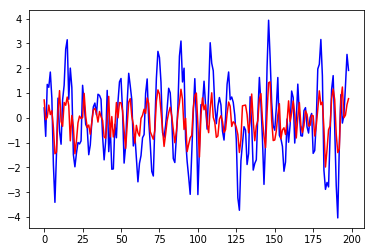

In [6]:
final_result = Kalman_filter(data)
final_result[0]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


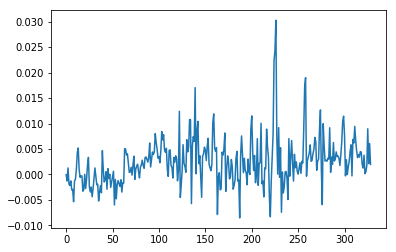

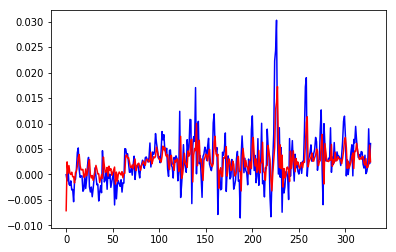

In [7]:
# Now, we will test with the real data, the M2 money suppy adjusted by the price index.
data_M2 = pd.read_csv('M2.csv', delimiter = ';', header = None, index_col = 0)
df = pd.DataFrame(data_M2)
M2 = df.iloc[0,:].convert_objects(convert_numeric = True)
M2 = np.array(M2)
M2_real = []

for i in M2:
    M2_real.append(i.replace(',','.'))

M2_real = np.transpose(np.array(M2_real).astype(np.float))

# We will transform the data a bit by taking its first logarithm difference (in order to obtain the stationarity)
diff_log_M2 = np.log(M2_real[1:]) - np.log(M2_real[:len(M2_real)-1])

# Visualize the new data
_ = plt.figure
_ = plt.plot(range(len(diff_log_M2)), diff_log_M2)
plt.show()

# Now, we have the data, let's apply the function
result_fig = Kalman_filter(diff_log_M2)

In [ ]:
# This section is designed to apply the Kalman filter in finance and economics. There are so many ways to extend this work.
# Next time, we will try to use the Kalman filter in some other applications such as prediction, Markov switching regime, etc.
# Another way to improve this work is to use other methods to estimate the model, or formulate more complicated models, not only
# the AR(2) process (could be ARMA(p,q) process), or use the GARCH model to capture the change in the volatility of error terms,
# because in this design, we restricted the error volatility to be unchanged.